In [1]:
%pip -q install ipython langchain_groq dotenv

Note: you may need to restart the kernel to use updated packages.


In [1]:
from dotenv import load_dotenv
load_dotenv(dotenv_path=".env")
from langgraph.graph import StateGraph, END, add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode
from langchain_community.tools import TavilySearchResults
from langchain_core.messages import HumanMessage
from typing import TypedDict, Annotated
from langchain_groq import ChatGroq

memory = MemorySaver()

llm = ChatGroq(model="llama-3.1-8b-instant")

search_tool = TavilySearchResults(max_results=2)

class State(TypedDict):
    messages: Annotated[list,add_messages]

tools = [search_tool]

llm_with_tools = llm.bind_tools(tools=tools)

def model_node(state: State):
    return {
        "messages": [llm_with_tools.invoke(state["messages"])]
    }

def tools_router(state: State):
    last_message = state["messages"][-1]
    if hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0:
        return "tools_node"
    else:
        return END

graph = StateGraph(State)
graph.add_node("model_node",model_node)
graph.add_node("tools_node", ToolNode(tools=tools))
graph.set_entry_point("model_node")


graph.add_conditional_edges("model_node", tools_router)
graph.add_edge("tools_node", "model_node")

app = graph.compile(checkpointer=memory, interrupt_before=['tools_node'])



C:\Users\Admin\AppData\Local\Temp\ipykernel_1416\3844927770.py:15: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search_tool = TavilySearchResults(max_results=2)


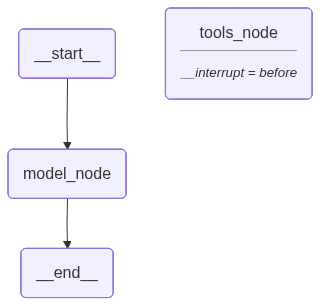

In [2]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [6]:
config = {
    "configurable": {
        "thread_id": 1
    }
}

events = app.stream({
    "messages": [HumanMessage(content="what is the current weather in New Delhi")]
}, 
config=config,
stream_mode="values"
)

for i,event in enumerate(events):
    print("event index",i)
    event['messages'][-1].pretty_print()

event index 0
================================ Human Message =================================

what is the current weather in New Delhi
event index 1
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (m3thb9t0t)
 Call ID: m3thb9t0t
  Args:
    query: current weather in New Delhi today


In [4]:
events = app.stream(None, config, stream_mode="values")
for event in events:
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (397m1as6z)
 Call ID: 397m1as6z
  Args:
    query: current weather in New Delhi
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Delhi weather in September 2025 - Weather25.com", "url": "https://www.weather25.com/asia/india/delhi?page=month&month=September", "content": "| 14 Partly cloudy 36° /29° | 15 Partly cloudy 37° /29° | 16 Partly cloudy 38° /29° | 17 Partly cloudy 39° /30° | 18 Patchy rain possible 37° /29° | 19 Light rain shower 36° /27° | 20 Light rain shower 32° /25° |\n| 21 Patchy rain possible 31° /25° | 22 Light rain shower 35° /28° | 23 Light rain shower 34° /28° | 24 Partly cloudy 36° /28° | 25 Light rain shower 35° /27° | 26 Patchy rain possible 35° /27° | 27 Sunny 35° /27° | [...] Partly cloudy\nLight rain shower\nLight rain shower\nPatchy rain possible\nPatchy rain possib